# Open and run analysis on multiple polygons
* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environments
* **Products used:** 
[`ga_ls5t_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[`ga_ls7e_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[`ga_ls8c_ard_3`](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

### Background
Many users need to run analyses on their own areas of interest. A common use case involves running the same analysis across multiple polygons in a shapefile.

### Description
If we have a vector file containing multiple polygons, we can use the python package [fiona](https://fiona.readthedocs.io/en/latest/manual.html#reading-vector-data) to open it and iterate through the files, retrieving and plotting data from Digital Earth Australia.
1. First we open the polygon using the [fiona](https://fiona.readthedocs.io/en/latest/manual.html#reading-vector-data) package
2. Then we retrieve data from DEA
3. Then we calculate NDVI as an example analysis
4. Then we plot NDVI for the polygon


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Please note the use of `datacube utilities` package `geometry`: 
this is important for saving the coordinate reference system of the incoming shapefile in a format that the Digital Earth Australia query can understand. 
It has the same name as the `shapely.geometry` package, and should be imported later as in the cell below.

In [38]:
%matplotlib inline

import datacube
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry

import sys
import xarray as xr

from datacube.storage import masking
from datacube.utils import geometry

sys.path.append('../../Scripts') #probably need to change this after you move the code
sys.path.append('../Scripts')

from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_plotting import rgb
from dea_temporaltools import time_buffer

### Connect to the datacube
Give your datacube app a unique name. 
Ideally, this will be the same as the notebook file name.

In [20]:
dc = datacube.Datacube(app='Analyse_multiple_polygons')

### Import our vector file containing multiple polygons
Set the path to the location of the file

In [22]:
# This is the path location of our polygon file. You can change this to another file.
multiple_polys_file = '../../Supplementary_data/Analyse_multiple_polygons/multiple_polys.shp'

Use the python package `fiona` to open and iterate through the polygon file. Working with vector files it's important to save and preserve the Coordinate Reference System, the CRS, so we save this from the `well known text`.

### Look at the structure of the vector file
Import the file and take a look at how the file is structured so we understand what we are iterating through. 
There are two polygons in the file.

In [33]:
#use the fiona package to open the vector file of the polygons
with fiona.open(multiple_polys_file, 'r') as source:
    #explicity set the coordinate reference system from the source file
    crs=source.crs_wkt
    #iterate through the polygon file and have a look at the dictionaries that we've got in the {'key': 'value'} format.  
    for record in source:
        print(record)

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('id', 2)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(980959.7463502702, -3560845.1440404137), (983880.0240901897, -3561060.826135304), (983743.6347701667, -3563575.060756798), (980756.4213970329, -3563330.2800234086), (980959.7463502702, -3560845.1440404137)]]}}
{'type': 'Feature', 'id': '1', 'properties': OrderedDict([('id', 1)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(974705.4936402615, -3565359.491861172), (977625.771380181, -3565575.173956062), (977489.382060158, -3568089.4085775563), (974502.1686870242, -3567844.627844167), (974705.4936402615, -3565359.491861172)]]}}


Choose a time of interest to look at your polygon

In [45]:
time_of_interest = '2019-02-01'

Then set a buffer around the time to get some data within

In [46]:
early_buffer, late_buffer = time_buffer(time_of_interest, buffer='30 days')

## Demonstrate loading and analysing data for multiple polygons in a loop
Load our query for each polygon, demonstrate calculating an index using dea_bandindices (NDVI) and plotting results 

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Ignoring SLC-off observations for ls7
    No data for ga_ls7e_ard_3
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 3 observations as a dask array


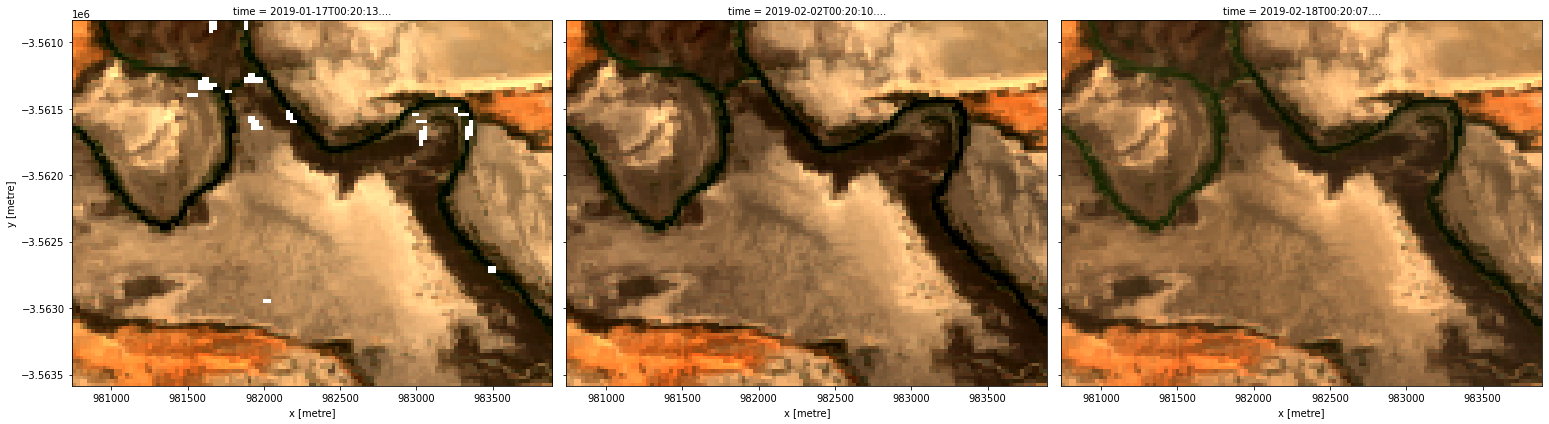

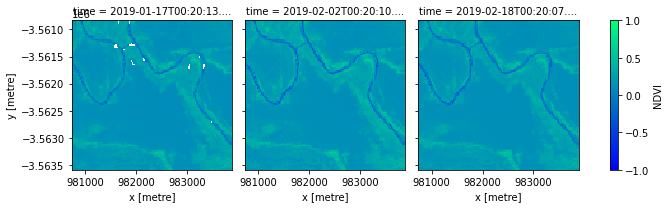

Loading ga_ls5t_ard_3 data
    No data for ga_ls5t_ard_3
Loading ga_ls7e_ard_3 data
    Ignoring SLC-off observations for ls7
    No data for ga_ls7e_ard_3
Loading ga_ls8c_ard_3 data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 3 observations as a dask array


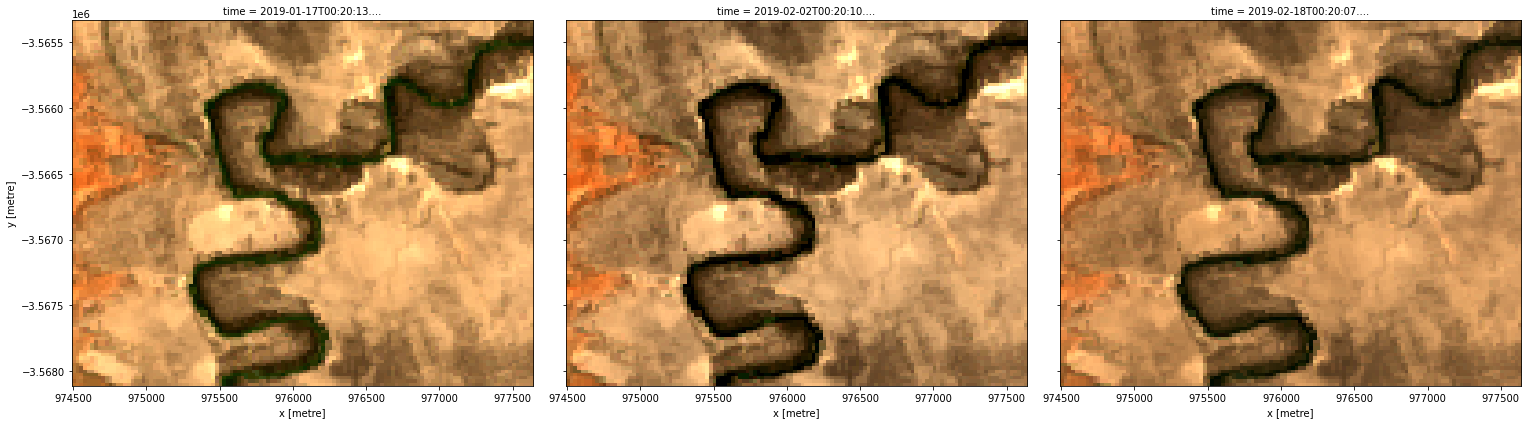

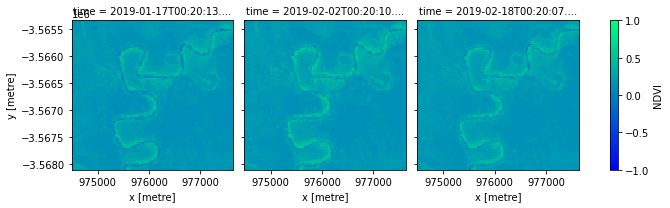

In [47]:
# Load available data from all three Landsat satellites
with fiona.open(multiple_polys_file) as shapes:    
    #get crs object from polygon file using datacube.
    crs = geometry.CRS(shapes.crs_wkt)
    for feature in shapes:
        #get feature geometry
        feature_geometry=feature['geometry']
        #create datacube geometry.Geometry object
        geom = geometry.Geometry(feature_geometry, crs=crs)
        
        #this sets up our datacube query based off the corresponding polygon and the chosen date, the bands we wish to use . 
        query = {'geopolygon': geom,
         'time': (early_buffer,late_buffer),
         'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir'],
         'resolution':(-25,25)
        }
        #create a dataset to load our data into for the polygon of i
        landsat_ds = load_ard(dc=dc, 
                              products=['ga_ls5t_ard_3', 
                                        'ga_ls7e_ard_3', 
                                        'ga_ls8c_ard_3'],
                              #min_gooddata=0.99, #only take uncloudy scenes
                              ls7_slc_off = False, #ignore stripy data for demonstration    
                              output_crs='EPSG:3577',
                              align=(15, 15),
                              group_by='solar_day',
                              dask_chunks={'time':1},
                              **query)
        
        #plot each polygon dataset in rgb
        rgb(landsat_ds, col='time')
        
        #calculate NDVI for each polygon dataset
        ndvi = calculate_indices(landsat_ds, index='NDVI', collection='ga_ls_3')
        
        #plot NDVI for each polygon for the time query
        ndvi.NDVI.plot(col='time', cmap='winter', vmin=-1, vmax=1)
        plt.show()

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2020

**Compatible `datacube` version:** 

In [48]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)